# Problem Statement :
## Objective :
* Apply concept of Self Supervised Learning Concept for face classification
* Can be used to create personalised models for different sets of faces using the extensively trained feature extractor on pretext task

## Approach :
* Instead of Collecting lots of annotated data for every individual, we can exploit the fact that all faces have almost the same number of features. So we can create feature extractor using lots of unlabelled data
* The pretext task to get pseudo labels is **Clustering**
* Then we train it on annotated data that we have (much less in qty than the unlabelled data)

In [7]:
import torch
import torchvision
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import sklearn
import pickle

from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from pathlib import Path
from typing import List, Dict, Tuple
from collections import defaultdict
from matplotlib import patches, text, patheffects
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn import datasets
from PIL import Image
from tqdm.auto import tqdm

try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Data Access and Preprocessing

## Analysing Images

### Labelled Faces in the Wild Dataset

In [9]:
data = datasets.fetch_lfw_people(min_faces_per_person=50, resize=1, color=True)

In [10]:
X = np.array(data['data'])
images = np.array(data['images'])
targets = np.array(data['target'])
target_names = np.array(data['target_names'])

In [11]:
images[0]

array([[[0.38431373, 0.30588236, 0.20784314],
        [0.40392157, 0.3254902 , 0.22745098],
        [0.41960785, 0.34117648, 0.23529412],
        ...,
        [0.36078432, 0.31764707, 0.19215687],
        [0.3647059 , 0.32941177, 0.2       ],
        [0.34509805, 0.32156864, 0.19607843]],

       [[0.4117647 , 0.33333334, 0.23529412],
        [0.4       , 0.32156864, 0.22352941],
        [0.40784314, 0.32941177, 0.22352941],
        ...,
        [0.35686275, 0.31764707, 0.18039216],
        [0.38039216, 0.3372549 , 0.21176471],
        [0.38039216, 0.34509805, 0.21568628]],

       [[0.43137255, 0.3529412 , 0.25490198],
        [0.4117647 , 0.33333334, 0.23529412],
        [0.4117647 , 0.33333334, 0.22745098],
        ...,
        [0.33333334, 0.29411766, 0.15686275],
        [0.3882353 , 0.34509805, 0.21960784],
        [0.3882353 , 0.3529412 , 0.22352941]],

       ...,

       [[0.1882353 , 0.19607843, 0.1764706 ],
        [0.19215687, 0.2       , 0.18039216],
        [0.18431373, 0

Image shape : (125, 94, 3)


(-0.5, 93.5, 124.5, -0.5)

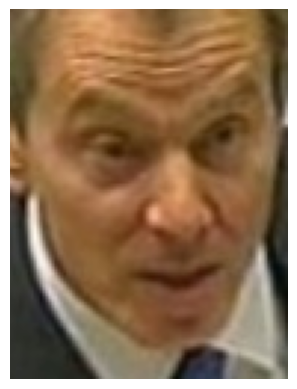

In [12]:
print(f"Image shape : {images[0].shape}")
plt.imshow(images[0])
plt.axis(False)

In [13]:
len(X), len(images), len(targets), len(target_names)

(1560, 1560, 1560, 12)

In [14]:
np.unique(targets)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [15]:
np.unique(target_names)

array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Hugo Chavez', 'Jacques Chirac',
       'Jean Chretien', 'John Ashcroft', 'Junichiro Koizumi',
       'Serena Williams', 'Tony Blair'], dtype='<U17')

In [16]:
for target in np.unique(targets):
  print(f"{target_names[target]} : {np.count_nonzero(targets==target)}")

Ariel Sharon : 77
Colin Powell : 236
Donald Rumsfeld : 121
George W Bush : 530
Gerhard Schroeder : 109
Hugo Chavez : 71
Jacques Chirac : 52
Jean Chretien : 55
John Ashcroft : 53
Junichiro Koizumi : 60
Serena Williams : 52
Tony Blair : 144


### Removing massive count data (may lead to imbalanced dataset)

The massive count data are the images of :
* George W Bush
* Colin Powell

These account for almost half of the dataset

In [17]:
actual_training_data = defaultdict(list)
total_data = len(images)

file_path = "/content/drive/MyDrive/Machine Learning Project's Saved Data/Face Classification using SSL/Actual Training LFW data"

if os.path.isfile(file_path):

  file = open(file_path, 'rb')
  actual_training_data = pickle.load(file)
  file.close()

else :

  for index in range(total_data):

    if(targets[index]!=1 and targets[index]!=3):
      actual_training_data['images'].append(images[index])
      actual_training_data['target'].append(targets[index])
      actual_training_data['target_names'].append(target_names[targets[index]])


print(f"Total data count : {total_data}")
print(f"Final data count : {len(actual_training_data['images'])}")


Total data count : 1560
Final data count : 794


In [18]:
actual_training_data['images'][0]

array([[[0.38431373, 0.30588236, 0.20784314],
        [0.40392157, 0.3254902 , 0.22745098],
        [0.41960785, 0.34117648, 0.23529412],
        ...,
        [0.36078432, 0.31764707, 0.19215687],
        [0.3647059 , 0.32941177, 0.2       ],
        [0.34509805, 0.32156864, 0.19607843]],

       [[0.4117647 , 0.33333334, 0.23529412],
        [0.4       , 0.32156864, 0.22352941],
        [0.40784314, 0.32941177, 0.22352941],
        ...,
        [0.35686275, 0.31764707, 0.18039216],
        [0.38039216, 0.3372549 , 0.21176471],
        [0.38039216, 0.34509805, 0.21568628]],

       [[0.43137255, 0.3529412 , 0.25490198],
        [0.4117647 , 0.33333334, 0.23529412],
        [0.4117647 , 0.33333334, 0.22745098],
        ...,
        [0.33333334, 0.29411766, 0.15686275],
        [0.3882353 , 0.34509805, 0.21960784],
        [0.3882353 , 0.3529412 , 0.22352941]],

       ...,

       [[0.1882353 , 0.19607843, 0.1764706 ],
        [0.19215687, 0.2       , 0.18039216],
        [0.18431373, 0

### Relabel the remaining data
This is done to bring consistancy in data, in the previous block we have removed massive count data, their labels were 1,3. To make the rest of the data labels in the range of 0-9 we will relabel the data

In [19]:
np.unique(actual_training_data['target_names'])

array(['Ariel Sharon', 'Donald Rumsfeld', 'Gerhard Schroeder',
       'Hugo Chavez', 'Jacques Chirac', 'Jean Chretien', 'John Ashcroft',
       'Junichiro Koizumi', 'Serena Williams', 'Tony Blair'], dtype='<U17')

In [20]:
np.unique(actual_training_data['target'])

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [21]:
target_name_to_label_training_dict = {}
for index, name in enumerate(np.unique(actual_training_data['target_names'])):
  target_name_to_label_training_dict[name] = index

target_name_to_label_training_dict

{'Ariel Sharon': 0,
 'Donald Rumsfeld': 1,
 'Gerhard Schroeder': 2,
 'Hugo Chavez': 3,
 'Jacques Chirac': 4,
 'Jean Chretien': 5,
 'John Ashcroft': 6,
 'Junichiro Koizumi': 7,
 'Serena Williams': 8,
 'Tony Blair': 9}

In [ ]:
for index in range(len(actual_training_data['images'])):

  actual_training_data['target'][index] = target_name_to_label_training_dict[actual_training_data['target_names'][index]]

np.unique(actual_training_data['target'])

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
# file = open("/content/drive/MyDrive/Machine Learning Project's Saved Data/Face Classification using SSL/Actual Training LFW data", 'wb')
# pickle.dump(actual_training_data, file)
# file.close()

Total Images : 52


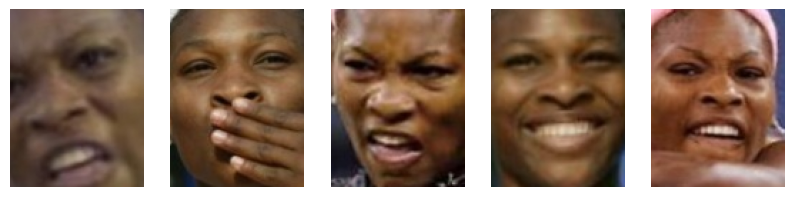

In [22]:
actual_training_data_target_np = np.array(actual_training_data['target'])
indices = np.where(actual_training_data_target_np==8)[0]
print(f"Total Images : {len(indices)}")

random_images_idx = random.sample(list(indices), 5)

fig, ax = plt.subplots(nrows=1, ncols=5, figsize = (10,30))

for index, idx in enumerate(random_images_idx):

  ax[index].imshow(actual_training_data['images'][idx])
  ax[index].axis(False)


### Extracting Unlabelled Data

In [23]:
file_path = "/content/drive/MyDrive/Machine Learning Project's Saved Data/Face Classification using SSL/Entire LFW data"

if os.path.isfile(file_path):

  file = open(file_path, 'rb')
  entire_data = pickle.load(file)
  file.close()

else :
  entire_data = datasets.fetch_lfw_people(resize=1, color=True)

  file = open(file_path, 'wb')
  pickle.dump(actual_training_data, file)
  file.close()

len(np.unique(entire_data['target']))

5749

In [24]:
len(entire_data['images'])

13233

In [25]:
# Label to name Dictionary
label_to_target_name_dict = {}
for index , target_name in enumerate(entire_data['target_names']):
  label_to_target_name_dict[index] = target_name

len(label_to_target_name_dict)

5749

### Creating Unlabelled data
* Remove the 1500 images that we have previously chosen as Actual Dataset
* After removal choose 6500 images (done due to RAM shortage while dealing with 11000 images)

In [26]:
unlabelled_dataset = defaultdict(list)
entire_data_count = len(entire_data['images'])

names_to_remove = list(target_name_to_label_training_dict.keys())

for index in range(entire_data_count):

  if label_to_target_name_dict[entire_data['target'][index]] not in target_names:

    unlabelled_dataset['images'].append(entire_data['images'][index])

unlabelled_dataset['images'] = random.sample(unlabelled_dataset['images'], 6500)

len(unlabelled_dataset['images'])

6500

In [27]:
print(f"Unlabelled Data : {len(unlabelled_dataset['images'])}")
print(f"Total Data : {entire_data_count}")

Unlabelled Data : 6500
Total Data : 13233


In [28]:
# Shape of Unlabelled image
unlabelled_dataset['images'][0].shape

(125, 94, 3)

In [29]:
# Value Contained in it
unlabelled_dataset['images'][1]

array([[[0.44313726, 0.38039216, 0.23921569],
        [0.5254902 , 0.45490196, 0.29803923],
        [0.627451  , 0.5372549 , 0.3647059 ],
        ...,
        [0.32156864, 0.2784314 , 0.16078432],
        [0.30980393, 0.27450982, 0.16078432],
        [0.28235295, 0.25490198, 0.14509805]],

       [[0.43529412, 0.38039216, 0.23529412],
        [0.5176471 , 0.45882353, 0.2901961 ],
        [0.61960787, 0.5372549 , 0.36078432],
        ...,
        [0.3254902 , 0.27450982, 0.14901961],
        [0.31764707, 0.27450982, 0.15686275],
        [0.3019608 , 0.26666668, 0.15294118]],

       [[0.43137255, 0.38431373, 0.23529412],
        [0.50980395, 0.45882353, 0.28627452],
        [0.60784316, 0.5372549 , 0.35686275],
        ...,
        [0.30980393, 0.25882354, 0.13333334],
        [0.30980393, 0.26666668, 0.14901961],
        [0.31764707, 0.28235295, 0.16078432]],

       ...,

       [[0.41568628, 0.6509804 , 0.84705883],
        [0.4       , 0.6431373 , 0.8352941 ],
        [0.36862746, 0

(-0.5, 93.5, 124.5, -0.5)

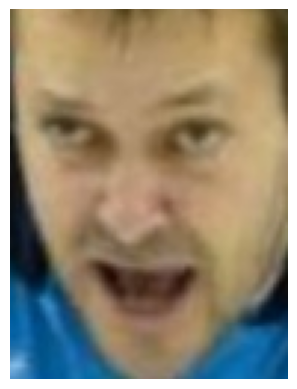

In [30]:
plt.imshow(unlabelled_dataset['images'][1])
plt.axis(False)

### Resize and convert data to Tensor

Making all the data of uniform size

(-0.5, 63.5, 63.5, -0.5)

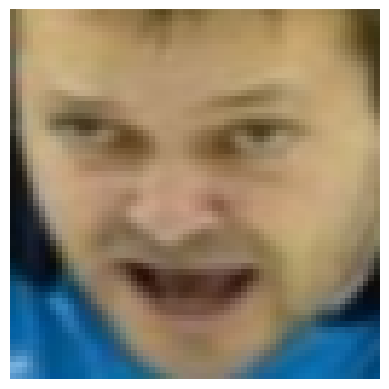

In [31]:
img_transforms = transforms.Compose([transforms.Resize(size=(64,64), antialias=True)])

transformed_img = img_transforms(torch.Tensor(unlabelled_dataset['images'][1]).permute(2,0,1))
plt.imshow(transformed_img.permute(1,2,0))
plt.axis(False)

In [32]:
transformed_img

tensor([[[0.4680, 0.5909, 0.7010,  ..., 0.3243, 0.3188, 0.3018],
         [0.4647, 0.5788, 0.6831,  ..., 0.3108, 0.3026, 0.3076],
         [0.4724, 0.5782, 0.6736,  ..., 0.2942, 0.2743, 0.2746],
         ...,
         [0.4523, 0.4566, 0.4128,  ..., 0.0553, 0.0219, 0.0039],
         [0.4285, 0.4030, 0.3483,  ..., 0.0304, 0.0029, 0.0019],
         [0.3534, 0.3251, 0.2777,  ..., 0.0183, 0.0028, 0.0096]],

        [[0.4085, 0.5140, 0.6133,  ..., 0.2683, 0.2735, 0.2671],
         [0.4151, 0.5147, 0.6077,  ..., 0.2513, 0.2537, 0.2694],
         [0.4187, 0.5149, 0.6047,  ..., 0.2327, 0.2252, 0.2398],
         ...,
         [0.6826, 0.6958, 0.6600,  ..., 0.3405, 0.2971, 0.2767],
         [0.6631, 0.6457, 0.6010,  ..., 0.3134, 0.2796, 0.2864],
         [0.6019, 0.5828, 0.5476,  ..., 0.3091, 0.2926, 0.3086]],

        [[0.2574, 0.3414, 0.4216,  ..., 0.1400, 0.1532, 0.1531],
         [0.2594, 0.3376, 0.4115,  ..., 0.1163, 0.1272, 0.1486],
         [0.2691, 0.3423, 0.4113,  ..., 0.0920, 0.0935, 0.

In [33]:
transformed_img.shape, transformed_img.flatten().shape

(torch.Size([3, 64, 64]), torch.Size([12288]))

## Flattening Image Data

This is done so that we can run Kmeans to generate Pseudo Labels for the unlabelled images

In [34]:
file_path = "/content/drive/MyDrive/Machine Learning Project's Saved Data/Face Classification using SSL/ Colour Face Flattened Data (half)"

if os.path.isfile(file_path):

  # Loading Saved data to save loading time
  file = open(file_path, 'rb')
  image_data_np = pickle.load(file)
  file.close()

else :
  image_data = []

  print("Flattening Data ...")
  for idx, image in enumerate(unlabelled_dataset['images']):
    # Bringing image to (Colour Channel, Height, Width) format for transformation
    image = torch.tensor(image).permute(2,0,1)
    image_data.append(img_transforms(image).flatten())

  image_data_np = np.array([flattened_image.numpy() for flattened_image in image_data])
  print("Data Flattened !!!")

  # Creating Pickle file for later use
  file = open(file_path, 'wb')
  pickle.dump(image_data_np, file)
  file.close()

image_data_np,image_data_np.shape

(array([[0.00359976, 0.00338971, 0.0134518 , ..., 0.5208944 , 0.5379555 ,
         0.5358038 ],
        [0.5423521 , 0.5820112 , 0.65162396, ..., 0.08376181, 0.10338036,
         0.10193738],
        [0.01960784, 0.02657211, 0.04111761, ..., 0.13262519, 0.1595461 ,
         0.18845712],
        ...,
        [0.678207  , 0.67821145, 0.6639408 , ..., 0.10902534, 0.12215593,
         0.12304688],
        [0.2249344 , 0.23172948, 0.27322343, ..., 0.8902973 , 0.943062  ,
         0.9606952 ],
        [0.19705467, 0.17875768, 0.19469339, ..., 0.7521735 , 0.86390835,
         0.8814659 ]], dtype=float32),
 (6500, 12288))

# Generating Pseudo Labels

## Pretext Task : Clustering Unlabelled Data

### Algorithm used : KMeans

In [35]:
N_CLUSTERS = 10 # Hyper Parameter
file_path = "/content/drive/MyDrive/Machine Learning Project's Saved Data/Face Classification using SSL/Kmeans labels 10 clusters (half size data)"

if os.path.isfile(file_path) :

  # Loading Saved data to save loading time
  file = open(file_path, 'rb')
  labels = pickle.load(file)
  file.close()

else :

  # Running K means to generate Pseudo Labels
  kmeans = KMeans(n_clusters = N_CLUSTERS, n_init = 10)
  print("Fitting data ...")
  kmeans.fit(image_data_np)
  print("Fitted data !!!")
  labels = kmeans.labels_

  # Creating Pickle file for later use
  file = open(file_path, 'wb')
  pickle.dump(kmeans.labels_, file)
  file.close()

labels

array([6, 4, 6, ..., 4, 8, 2], dtype=int32)

### Create and Save dataset for Pre-Training

In [36]:
class CustomDataset(Dataset):

  def __init__(self, image_list, labels, transform = None) -> None:

    self.image_list = image_list
    self.labels = labels
    self.transform = transform

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, index):

    if self.transform is not None :
      transformed_img = self.transform(torch.tensor(self.image_list[index]).permute(2,0,1))

    return transformed_img, self.labels[index]

In [37]:
pretext_task_dataset = CustomDataset(image_list = unlabelled_dataset['images'],
                                     labels = labels,
                                     transform=img_transforms)
len(pretext_task_dataset)

6500

In [38]:
BATCH_SIZE = 128 #Hyper Parameter
NUM_WORKERS = os.cpu_count()

pretext_task_dataloader = DataLoader(dataset=pretext_task_dataset,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle = True)

len(pretext_task_dataloader)

51

In [39]:
images , labels = next(iter(pretext_task_dataloader))
images, labels

(tensor([[[[0.1692, 0.1677, 0.1737,  ..., 0.1813, 0.1597, 0.1348],
           [0.1659, 0.1643, 0.1632,  ..., 0.1969, 0.1832, 0.1533],
           [0.1524, 0.1504, 0.1508,  ..., 0.1971, 0.2025, 0.1896],
           ...,
           [0.1474, 0.1461, 0.1421,  ..., 0.1693, 0.1346, 0.1228],
           [0.1423, 0.1452, 0.1432,  ..., 0.1447, 0.1279, 0.1169],
           [0.1373, 0.1462, 0.1455,  ..., 0.1357, 0.1185, 0.1063]],
 
          [[0.1653, 0.1567, 0.1503,  ..., 0.1693, 0.1526, 0.1309],
           [0.1611, 0.1495, 0.1381,  ..., 0.1807, 0.1721, 0.1482],
           [0.1449, 0.1347, 0.1232,  ..., 0.1773, 0.1865, 0.1750],
           ...,
           [0.1241, 0.1258, 0.1254,  ..., 0.1263, 0.1008, 0.0926],
           [0.1230, 0.1270, 0.1299,  ..., 0.1108, 0.1031, 0.0951],
           [0.1280, 0.1326, 0.1320,  ..., 0.1047, 0.0992, 0.0901]],
 
          [[0.1860, 0.1734, 0.1648,  ..., 0.1766, 0.1523, 0.1230],
           [0.1807, 0.1700, 0.1534,  ..., 0.1880, 0.1722, 0.1416],
           [0.1645, 0.15

In [40]:
images.shape

torch.Size([128, 3, 64, 64])

# Self Supervised Pre-Training

## Feature Extractor

### Device Agnostics

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Model Architecture

In [ ]:
class TinyVGG(nn.Module):

  def __init__(self, n_clusters : int) -> None:
     super().__init__()

     self.conv_layer_1 = nn.Sequential(nn.Conv2d(in_channels=3,
                                                 out_channels=16,
                                                 kernel_size=3),
                                       nn.ReLU())

     self.conv_maxpool_layer_1 = nn.Sequential(nn.Conv2d(in_channels=16,
                                                         out_channels=32,
                                                         kernel_size=3),
                                               nn.ReLU(),
                                               nn.MaxPool2d(kernel_size=2))

     self.conv_layer_2 = nn.Sequential(nn.Conv2d(in_channels=32,
                                                 out_channels=64,
                                                 kernel_size=3),
                                       nn.ReLU())

     self.conv_maxpool_layer_2 = nn.Sequential(nn.Conv2d(in_channels=64,
                                                    out_channels=128,
                                                    kernel_size=3),
                                          nn.ReLU(),
                                          nn.MaxPool2d(kernel_size=2))

     self.classifier = nn.Sequential(nn.Flatten(),
                                     nn.Linear(in_features = 13*13*128,
                                               out_features = 128),
                                     nn.ReLU(),
                                     nn.Linear(in_features = 128,
                                               out_features = n_clusters))

  def forward(self, x : torch.Tensor) -> torch.Tensor:

     return self.classifier(self.conv_maxpool_layer_2(self.conv_layer_2(self.conv_maxpool_layer_1(self.conv_layer_1(x)))))

In [ ]:
model = TinyVGG(n_clusters=N_CLUSTERS).to(device)
model, next(model.parameters()).device

(TinyVGG(
   (conv_layer_1): Sequential(
     (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
     (1): ReLU()
   )
   (conv_maxpool_layer_1): Sequential(
     (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
     (1): ReLU()
     (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (conv_layer_2): Sequential(
     (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
     (1): ReLU()
   )
   (conv_maxpool_layer_2): Sequential(
     (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
     (1): ReLU()
     (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (classifier): Sequential(
     (0): Flatten(start_dim=1, end_dim=-1)
     (1): Linear(in_features=21632, out_features=128, bias=True)
     (2): ReLU()
     (3): Linear(in_features=128, out_features=10, bias=True)
   )
 ),
 device(type='cuda', index=0))

### Sanity Check

In [ ]:
summary(model, input_size = [1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 10]                   --
├─Sequential: 1-1                        [1, 16, 62, 62]           --
│    └─Conv2d: 2-1                       [1, 16, 62, 62]           448
│    └─ReLU: 2-2                         [1, 16, 62, 62]           --
├─Sequential: 1-2                        [1, 32, 30, 30]           --
│    └─Conv2d: 2-3                       [1, 32, 60, 60]           4,640
│    └─ReLU: 2-4                         [1, 32, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 32, 30, 30]           --
├─Sequential: 1-3                        [1, 64, 28, 28]           --
│    └─Conv2d: 2-6                       [1, 64, 28, 28]           18,496
│    └─ReLU: 2-7                         [1, 64, 28, 28]           --
├─Sequential: 1-4                        [1, 128, 13, 13]          --
│    └─Conv2d: 2-8                       [1, 128, 26, 26]          73,856
│  

## Training Pretext model

### Loss Function and Optimiser

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(params=model.parameters(), lr=0.01, momentum=0.9)

### Forward Pass Check

In [ ]:
# Batching the unbatched data with batchsize = 1
image_1, label_1 = images[0].unsqueeze(dim=0), labels[0].unsqueeze(dim=0)

model.eval()
with torch.inference_mode():

  y_pred_logits = model(image_1.to(device))

  # Extracting Label from the predicted Logits
  y_pred_label = torch.argmax(torch.softmax(y_pred_logits, dim=1), dim=1)

  loss = loss_fn(y_pred_logits, label_1.type(torch.LongTensor).to(device))
  accuracy = (y_pred_label==label_1.to(device)).sum().item()/len(y_pred_label)

print(f"y_pred_logits : {y_pred_logits}")
print(f"Class Predicted : {y_pred_label} | Actual Class : {label_1}")
print(f"Loss : {loss}")
print(f"Accuracy : {accuracy}")

y_pred_logits : tensor([[-0.0770,  0.0777,  0.0023, -0.0328, -0.0576,  0.0173, -0.0858,  0.0837,
         -0.0624,  0.0423]], device='cuda:0')
Class Predicted : tensor([7], device='cuda:0') | Actual Class : tensor([5], dtype=torch.int32)
Loss : 2.277839183807373
Accuracy : 0.0


### Train Function

In [ ]:
def train(train_dataloader : DataLoader,
          model : nn.Module,
          loss_fn : nn.Module,
          optimiser : torch.optim.Optimizer,
          device) :

          """
          This function is the backbone of the training process

          Arguments :
            1) train_dataloader : dataloader object containing the batches of training data
            2) model : The model to be trained
            3) loss_fn : Loss function
            4) optimiser : Optimiser
            5) Device : Contains the current Device (GPU or CPU) to run the model on

          Returns :
            1) train_loss : Train Loss for the Current Epoch
            2) train_accuracy : Train Accuracy for the Current Epoch

          """

          model.train()

          train_loss = 0
          train_accuracy = 0

          for images, labels in train_dataloader:

            y_pred_logits = model(images.to(device))
            y_pred_labels = torch.argmax(torch.softmax(y_pred_logits, dim=1), dim=1)

            # Calculating the accuracy by comparing predicted labels with actual labels
            train_accuracy += (y_pred_labels == labels.to(device)).sum().item()/len(y_pred_labels)

            loss = loss_fn(y_pred_logits, labels.type(torch.LongTensor).to(device))
            train_loss+=loss.item()

            # Preventing gradient stockpiling
            optimiser.zero_grad()

            loss.backward()

            optimiser.step()

          train_loss /= len(train_dataloader)
          train_accuracy /= len(train_dataloader)

          return train_loss, train_accuracy

### Actual Training of Pretext Task

In [ ]:
EPOCHS = 80

results = defaultdict(list)

for epoch in tqdm(range(EPOCHS)) :

  train_loss, train_accuracy = train(train_dataloader=pretext_task_dataloader,
                                     model = model,
                                     loss_fn = loss_fn,
                                     optimiser = optimiser,
                                     device = device)

  results['Training Loss'].append(train_loss)
  results['Training Accuracy'].append(train_accuracy)

  if epoch%10==0:
    print(f"Training Loss : {train_loss} | Training Accuracy : {train_accuracy}")

  0%|          | 0/80 [00:00<?, ?it/s]

Training Loss : 2.2875433155134615 | Training Accuracy : 0.1273651960784314
Training Loss : 2.274274975645776 | Training Accuracy : 0.15041666666666667
Training Loss : 0.781691887215072 | Training Accuracy : 0.7008639705882352
Training Loss : 0.41537515819072723 | Training Accuracy : 0.843125
Training Loss : 0.26997286256621866 | Training Accuracy : 0.8984681372549019
Training Loss : 0.10579717875111337 | Training Accuracy : 0.9648774509803922
Training Loss : 0.23958917983862407 | Training Accuracy : 0.9214031862745098
Training Loss : 0.0006619149535967439 | Training Accuracy : 1.0


In [ ]:
results

defaultdict(list,
            {'Training Loss': [2.2875433155134615,
              2.211248933100233,
              2.3512019199483536,
              2.2827703812543083,
              2.276276195750517,
              2.274879109625723,
              2.2745316355836156,
              2.2742294984705307,
              2.2742221916423127,
              2.2741087043986603,
              2.274274975645776,
              2.2738129484887217,
              2.273272864958819,
              2.2712271914762607,
              2.247839506934671,
              2.0278227142259184,
              1.2398279192400914,
              0.9347407093235091,
              0.7291532287410661,
              0.7063473655897028,
              0.781691887215072,
              0.8095079981813244,
              0.5881552246271395,
              0.5866431763359145,
              0.5583165872330759,
              0.529832133475472,
              0.5786846408656999,
              0.41410203891641956,
              0.4135

### Loss and Accuracy Plots

In [ ]:
def loss_accuracy_plots(epochs : int, results : dict):
  fig, ax = plt.subplots(1,2, figsize = (8,6))

  ax[0].plot(range(epochs), results['Training Loss'])
  ax[0].set_title('Training Loss')
  ax[0].set_ylabel('Loss')
  ax[0].set_xlabel('Epochs')

  ax[1].plot(range(epochs), results['Training Accuracy'])
  ax[1].set_title('Training Accuracy')
  ax[1].set_ylabel('Accuracy')
  ax[1].set_xlabel('Epochs')

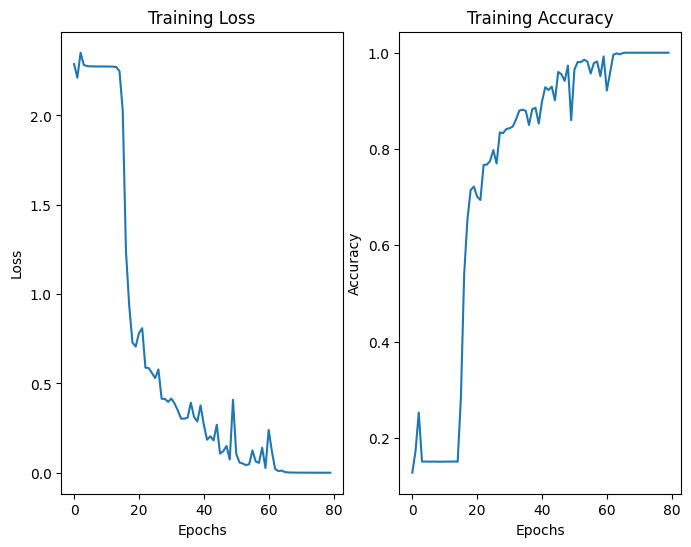

In [ ]:
loss_accuracy_plots(epochs = 80, results = results)

### Saving Model Parameters to save training time

In [ ]:
# torch.save(model.state_dict(), "/content/drive/MyDrive/Facial Data/Extracted Faces/feature extractor parameters (Tiny VGG Face) (Half size data)")

### Loading Saved Parameters

In [ ]:
model.load_state_dict(torch.load( "/content/drive/MyDrive/Facial Data/Extracted Faces/feature extractor parameters (Tiny VGG Face) (Half size data)", map_location=torch.device('cpu')))

<All keys matched successfully>

#Downstream task Training

## Data Preprocessing for train and test

### Splitting Data to Train, Test and Validation dataset

In [42]:
actual_training_data['images'][:3], actual_training_data['target'][:3]

([array([[[0.38431373, 0.30588236, 0.20784314],
          [0.40392157, 0.3254902 , 0.22745098],
          [0.41960785, 0.34117648, 0.23529412],
          ...,
          [0.36078432, 0.31764707, 0.19215687],
          [0.3647059 , 0.32941177, 0.2       ],
          [0.34509805, 0.32156864, 0.19607843]],
  
         [[0.4117647 , 0.33333334, 0.23529412],
          [0.4       , 0.32156864, 0.22352941],
          [0.40784314, 0.32941177, 0.22352941],
          ...,
          [0.35686275, 0.31764707, 0.18039216],
          [0.38039216, 0.3372549 , 0.21176471],
          [0.38039216, 0.34509805, 0.21568628]],
  
         [[0.43137255, 0.3529412 , 0.25490198],
          [0.4117647 , 0.33333334, 0.23529412],
          [0.4117647 , 0.33333334, 0.22745098],
          ...,
          [0.33333334, 0.29411766, 0.15686275],
          [0.3882353 , 0.34509805, 0.21960784],
          [0.3882353 , 0.3529412 , 0.22352941]],
  
         ...,
  
         [[0.1882353 , 0.19607843, 0.1764706 ],
          [0.1

In [43]:
train_images, test_and_validation_images, train_labels, test_and_validation_labels = train_test_split(actual_training_data['images'], actual_training_data['target'], test_size=0.25, random_state=42)
test_images, validation_images, test_labels, validation_labels = train_test_split(test_and_validation_images, test_and_validation_labels, test_size=0.5, random_state=42)


In [44]:
print(f"train_images shape : {np.array(train_images).shape}")
print(f"test_images shape : {np.array(test_images).shape}")
print(f"validation_images shape : {np.array(validation_images).shape}")
print(f"train_labels shape : {np.array(train_labels).shape}")
print(f"test_labels shape : {np.array(test_labels).shape}")
print(f"validation_labels shape : {np.array(validation_labels).shape}")

train_images shape : (595, 125, 94, 3)
test_images shape : (99, 125, 94, 3)
validation_images shape : (100, 125, 94, 3)
train_labels shape : (595,)
test_labels shape : (99,)
validation_labels shape : (100,)


### Create Train, Test and Validation Dataset

In [48]:
train_dataset = CustomDataset(image_list = train_images,
                                labels = train_labels,
                                transform = img_transforms)

test_dataset = CustomDataset(image_list = test_images,
                               labels = test_labels,
                               transform = img_transforms)

validation_dataset = CustomDataset(image_list = validation_images,
                                     labels = validation_labels,
                                     transform = img_transforms)

len(train_dataset), len(test_dataset), len(validation_dataset)

(595, 99, 100)

### Create Dataloader

In [49]:
train_dataloader = DataLoader(dataset = train_dataset,
                              batch_size = 16,
                              num_workers=NUM_WORKERS)

test_dataloader = DataLoader(dataset = test_dataset,
                             batch_size = 16,
                             num_workers = NUM_WORKERS)

validation_dataloader = DataLoader(dataset = validation_dataset,
                                   batch_size = 16,
                                   num_workers = NUM_WORKERS)

len(train_dataloader), len(test_dataloader), len(validation_dataloader)

(38, 7, 7)

In [50]:
images , labels = next(iter(test_dataloader))
images.shape, labels.shape

(torch.Size([16, 3, 64, 64]), torch.Size([16]))

## Downstream task model structure


In [ ]:
downstream_model = TinyVGG(n_clusters=N_CLUSTERS)
downstream_model.load_state_dict(model.state_dict())

NEW_CLASSES = 10

downstream_model.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(in_features = 13*13*128,
                                                      out_features = 128),
                                            nn.ReLU(),
                                            nn.Linear(in_features = 128,
                                                      out_features = 64),
                                            nn.ReLU(),
                                            nn.Linear(in_features=64,
                                                      out_features=32),
                                            nn.ReLU(),
                                            nn.Linear(in_features=32,
                                                      out_features=NEW_CLASSES))

downstream_model

TinyVGG(
  (conv_layer_1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (conv_maxpool_layer_1): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (conv_maxpool_layer_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=21632, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=32, bias=True)
    (6): ReLU()
    (7): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [ ]:
summary(downstream_model, input_size = [16,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [16, 10]                  --
├─Sequential: 1-1                        [16, 16, 62, 62]          --
│    └─Conv2d: 2-1                       [16, 16, 62, 62]          448
│    └─ReLU: 2-2                         [16, 16, 62, 62]          --
├─Sequential: 1-2                        [16, 32, 30, 30]          --
│    └─Conv2d: 2-3                       [16, 32, 60, 60]          4,640
│    └─ReLU: 2-4                         [16, 32, 60, 60]          --
│    └─MaxPool2d: 2-5                    [16, 32, 30, 30]          --
├─Sequential: 1-3                        [16, 64, 28, 28]          --
│    └─Conv2d: 2-6                       [16, 64, 28, 28]          18,496
│    └─ReLU: 2-7                         [16, 64, 28, 28]          --
├─Sequential: 1-4                        [16, 128, 13, 13]         --
│    └─Conv2d: 2-8                       [16, 128, 26, 26]         73,856
│  

## Training Dowstream task

### Sample Forward Pass

In [ ]:
downstream_model.eval()
with torch.inference_mode():

  test_loss = 0
  test_accuracy = 0

  for images, labels in test_dataloader:

    test_pred_logits = downstream_model(images.to(device))
    test_pred_labels = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)

    loss = loss_fn(test_pred_logits, labels.to(device))
    test_loss += loss.item()

    test_accuracy += (test_pred_labels==labels.to(device)).sum().item()/len(test_pred_labels)

  test_loss /= len(test_dataloader)
  test_accuracy /= len(test_dataloader)

test_loss, test_accuracy

(2.289966140474592, 0.08035714285714286)

### Loss Function and Optimiser

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(downstream_model.parameters(), lr=0.01, momentum=0.9)

### Test Function

In [ ]:
def test(test_dataloader : DataLoader,
         model : nn.Module,
         loss_fn : nn.Module,
         device):

  """
  This function is to check the performance of the model on test data

  Arguments :
    1) test_dataloader : dataloader object containing the batches of test data
    2) model : The model to be trained
    3) loss_fn : Loss function
    5) Device : Contains the current Device (GPU or CPU) to run the model on

  Returns :
    1) test_loss : Train Loss for the Current Epoch
    2) test_accuracy : Train Accuracy for the Current Epoch

  """

  model.eval()
  with torch.inference_mode():

    test_loss = 0
    test_accuracy = 0

    for images, labels in test_dataloader:

      test_pred_logits = model(images.to(device))
      test_pred_labels = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)

      loss = loss_fn(test_pred_logits, labels.to(device))
      test_loss += loss.item()

      test_accuracy += (test_pred_labels==labels.to(device)).sum().item()/len(test_pred_labels)

    test_loss /= len(test_dataloader)
    test_accuracy /= len(test_dataloader)

  return test_loss, test_accuracy


### Actual Downstream Task Training

In [ ]:
EPOCHS = 50

results_downstream_task = defaultdict(list)

for epoch in tqdm(range(EPOCHS)):

  train_loss, train_accuracy = train(train_dataloader = train_dataloader,
                                     model = downstream_model,
                                     loss_fn = loss_fn,
                                     optimiser = optimiser,
                                     device = device)
  test_loss, test_accuracy = test(test_dataloader = test_dataloader,
                                  model = downstream_model,
                                  loss_fn = loss_fn,
                                  device = device)

  results_downstream_task['train loss'].append(train_loss)
  results_downstream_task['train accuracy'].append(train_accuracy)
  results_downstream_task['test loss'].append(test_loss)
  results_downstream_task['test accuracy'].append(test_accuracy)

  print(f"Epoch : {epoch} | train loss = {train_loss} | test loss = {test_loss} | train accuracy = {train_accuracy} | test accuracy = {test_accuracy}")


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 0 | train loss = 2.105062550620029 | test loss = 1.9882320846830095 | train accuracy = 0.20888157894736842 | test accuracy = 0.2261904761904762
Epoch : 1 | train loss = 1.6412434734796222 | test loss = 1.6855950014931815 | train accuracy = 0.3958333333333333 | test accuracy = 0.3779761904761905
Epoch : 2 | train loss = 1.2551665619799965 | test loss = 1.652915017945426 | train accuracy = 0.5422149122807017 | test accuracy = 0.3869047619047619
Epoch : 3 | train loss = 1.1083743603605973 | test loss = 1.5386552810668945 | train accuracy = 0.6096491228070176 | test accuracy = 0.5625
Epoch : 4 | train loss = 1.0639174287942679 | test loss = 1.2475865568433488 | train accuracy = 0.6365131578947368 | test accuracy = 0.6607142857142857
Epoch : 5 | train loss = 0.7543804111743444 | test loss = 1.2644554717200143 | train accuracy = 0.7368421052631579 | test accuracy = 0.5654761904761905
Epoch : 6 | train loss = 0.5430146625363513 | test loss = 1.7648805209568568 | train accuracy = 0.819

In [ ]:
results_downstream_task

defaultdict(list,
            {'train loss': [2.105062550620029,
              1.6412434734796222,
              1.2551665619799965,
              1.1083743603605973,
              1.0639174287942679,
              0.7543804111743444,
              0.5430146625363513,
              0.5880358335240377,
              0.4466978929152614,
              0.398165690173444,
              0.2881784237504594,
              0.4267815105250568,
              0.3369775846367702,
              0.21040652751138336,
              0.12706805327616166,
              0.1707609009012422,
              0.04055754609685,
              0.016080267647517507,
              0.0032031644849417106,
              0.0004304226492907123,
              0.0002567439848552654,
              0.00020840850103828016,
              0.00017645746680596935,
              0.00015319476215786291,
              0.00013537813970082287,
              0.0001214082374947473,
              0.00011012630451047225,
              0.00

### Loss and Accuracy Plots

In [ ]:
def loss_accuracy_plots_train_test(epochs : dict, results : dict):
  fig, ax = plt.subplots(1,2, figsize = (8,6))

  ax[0].plot(range(epochs), results['train loss'], label = "Train")
  ax[0].plot(range(epochs), results['test loss'], label = "Test")
  ax[0].set_title('Loss Curves')
  ax[0].set_ylabel('Loss')
  ax[0].set_xlabel('Epochs')

  ax[1].plot(range(epochs), results['train accuracy'], label = "Train")
  ax[1].plot(range(epochs), results['test accuracy'], label = "Test")
  ax[1].set_title('Accuracy Curves')
  ax[1].set_ylabel('Accuracy')
  ax[1].set_xlabel('Epochs')

  plt.legend()


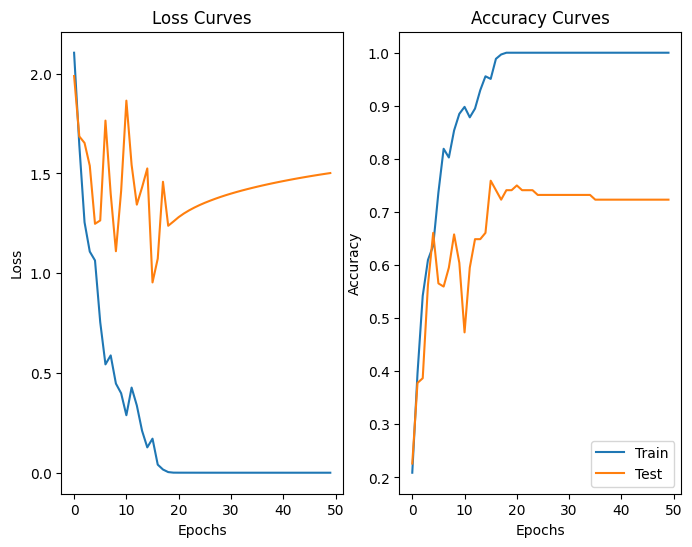

In [ ]:
loss_accuracy_plots_train_test(epochs = 50, results = results_downstream_task)

## Predictions

In [ ]:
def predictions(model : nn.Module, validation_dataloader : DataLoader, device):
  model.eval()
  with torch.inference_mode():

    for images, labels in validation_dataloader:

      y_pred_logits = model(images.to(device))
      y_pred_label = torch.argmax(torch.softmax(y_pred_logits, dim=1), dim=1)

      correct_prediction = (y_pred_label==labels.to(device)).sum().item()
      print(f"{correct_prediction} out of {len(y_pred_label)} correct")


In [ ]:
predictions(model = downstream_model, validation_dataloader=validation_dataloader, device=device)

12 out of 16 correct
13 out of 16 correct
13 out of 16 correct
11 out of 16 correct
13 out of 16 correct
13 out of 16 correct
4 out of 4 correct


# Without Self Supervised Learning

## Model Creation

In [ ]:
model_without_SSL = TinyVGG(n_clusters = 10).to(device)
model_without_SSL, next(model_without_SSL.parameters()).device

(TinyVGG(
   (conv_layer_1): Sequential(
     (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
     (1): ReLU()
   )
   (conv_maxpool_layer_1): Sequential(
     (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
     (1): ReLU()
     (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (conv_layer_2): Sequential(
     (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
     (1): ReLU()
   )
   (conv_maxpool_layer_2): Sequential(
     (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
     (1): ReLU()
     (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (classifier): Sequential(
     (0): Flatten(start_dim=1, end_dim=-1)
     (1): Linear(in_features=21632, out_features=128, bias=True)
     (2): ReLU()
     (3): Linear(in_features=128, out_features=10, bias=True)
   )
 ),
 device(type='cuda', index=0))

## Loss Function and Optimiser

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(model_without_SSL.parameters(), lr=0.01, momentum = 0.9)

## Training the Model

In [ ]:
EPOCHS = 100

results_without_SSL = defaultdict(list)

for epoch in tqdm(range(EPOCHS)):

  train_loss, train_accuracy = train(train_dataloader = train_dataloader,
                                     model = model_without_SSL,
                                     loss_fn = loss_fn,
                                     optimiser = optimiser,
                                     device = device)
  test_loss, test_accuracy = test(test_dataloader = test_dataloader,
                                  model = model_without_SSL,
                                  loss_fn = loss_fn,
                                  device = device)

  results_without_SSL['train loss'].append(train_loss)
  results_without_SSL['train accuracy'].append(train_accuracy)
  results_without_SSL['test loss'].append(test_loss)
  results_without_SSL['test accuracy'].append(test_accuracy)

  print(f"Epoch : {epoch} | train loss = {train_loss} | test loss = {test_loss} | train accuracy = {train_accuracy} | test accuracy = {test_accuracy}")


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 0 | train loss = 2.259200582378789 | test loss = 2.2610314914158414 | train accuracy = 0.16063596491228072 | test accuracy = 0.13392857142857142
Epoch : 1 | train loss = 2.2355810152856925 | test loss = 2.2461485862731934 | train accuracy = 0.19517543859649122 | test accuracy = 0.13392857142857142
Epoch : 2 | train loss = 2.2120714375847266 | test loss = 2.234513555254255 | train accuracy = 0.19517543859649122 | test accuracy = 0.13392857142857142
Epoch : 3 | train loss = 2.1470713489934017 | test loss = 2.1621217897960117 | train accuracy = 0.2066885964912281 | test accuracy = 0.13392857142857142
Epoch : 4 | train loss = 2.0012522747642114 | test loss = 2.0679445437022617 | train accuracy = 0.29550438596491224 | test accuracy = 0.25
Epoch : 5 | train loss = 1.7788670000277067 | test loss = 1.8538213797977992 | train accuracy = 0.36951754385964913 | test accuracy = 0.29464285714285715
Epoch : 6 | train loss = 1.4900064452698356 | test loss = 1.8146395172391618 | train accuracy 

In [ ]:
results_without_SSL

defaultdict(list,
            {'train loss': [2.259200582378789,
              2.2355810152856925,
              2.2120714375847266,
              2.1470713489934017,
              2.0012522747642114,
              1.7788670000277067,
              1.4900064452698356,
              1.3902293490736108,
              1.252304500655124,
              0.943431451132423,
              0.7307513685602891,
              0.567813325748399,
              0.43959471367691694,
              0.23975643084007683,
              0.16208076282821007,
              0.3775978237390518,
              0.15436709649278973,
              0.1666735314111544,
              0.14019231607615343,
              0.17203140775053558,
              0.14624768023962756,
              0.049181106128191675,
              0.09192098486298125,
              0.14172664020415632,
              0.03413754520490903,
              0.01699849597273322,
              0.14672495257359755,
              0.07073724079170886,
     

## Plotting Results

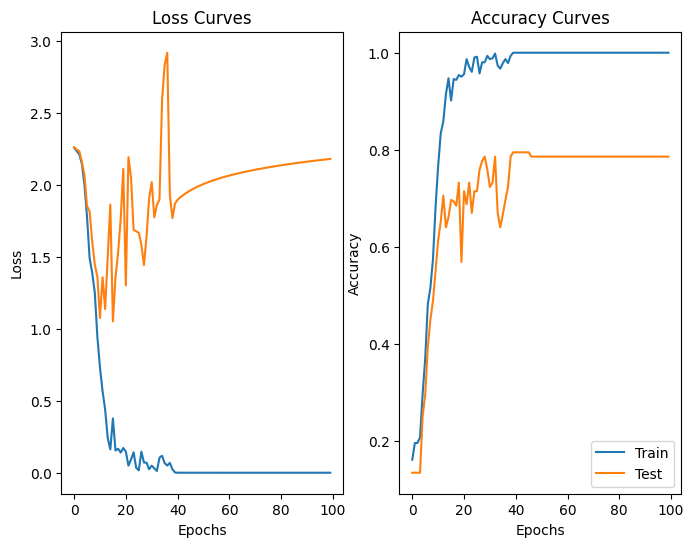

In [ ]:
loss_accuracy_plots_train_test(epochs=100, results=results_without_SSL)

## Predictions

In [ ]:
predictions(model = model_without_SSL, validation_dataloader=validation_dataloader, device=device)

11 out of 16 correct
13 out of 16 correct
15 out of 16 correct
12 out of 16 correct
15 out of 16 correct
13 out of 16 correct
4 out of 4 correct


# Transfer Learning Approach

## Loading Efficient_Net pretrained model

In [52]:
transfer_learning_model = torchvision.models.efficientnet_v2_s()
transfer_learning_model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

### Checking model input transformationa

In [53]:
weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[384]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

## Creating Datasets and DataLoaders for Transfer Learning model

### Datasets

In [55]:
train_dataset_TL = CustomDataset(image_list = train_images,
                                 labels = train_labels,
                                 transform = auto_transforms)

test_dataset_TL = CustomDataset(image_list = test_images,
                                labels = test_labels,
                                transform = auto_transforms)

validation_dataset_TL = CustomDataset(image_list = validation_images,
                                      labels = validation_labels,
                                      transform = auto_transforms)

len(train_dataset_TL), len(test_dataset_TL), len(validation_dataset_TL)

(595, 99, 100)

### DataLoader

In [56]:
train_dataloader_TL = DataLoader(dataset = train_dataset_TL,
                                 batch_size = 16,
                                 num_workers=NUM_WORKERS,
                                 shuffle = True)

test_dataloader_TL = DataLoader(dataset = test_dataset_TL,
                                batch_size = 16,
                                num_workers = NUM_WORKERS)

validation_dataloader_TL = DataLoader(dataset = validation_dataset_TL,
                                      batch_size = 16,
                                      num_workers = NUM_WORKERS)

len(train_dataloader_TL), len(test_dataloader_TL), len(validation_dataloader_TL)

(38, 7, 7)

In [57]:
image, label = train_dataset_TL[0]
image.shape, label

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(torch.Size([3, 384, 384]), 8)

## Finetuning for our use case

### Changing the Classifier Layer

In [ ]:
transfer_learning_model.classifier = nn.Sequential(nn.Dropout(p=0.2, inplace=True),
                                                   nn.Linear(in_features=1280, out_features=10, bias=True))
summary(transfer_learning_model,
        input_size = [1,3, 384, 384],
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 384, 384]     [1, 10]              --                   True
├─Sequential (features)                                      [1, 3, 384, 384]     [1, 1280, 12, 12]    --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 384, 384]     [1, 24, 192, 192]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 384, 384]     [1, 24, 192, 192]    648                  True
│    │    └─BatchNorm2d (1)                                  [1, 24, 192, 192]    [1, 24, 192, 192]    48                   True
│    │    └─SiLU (2)                                         [1, 24, 192, 192]    [1, 24, 192, 192]    --                   --
│    └─Sequential (1)                                        [1, 24, 192, 192]    [1, 24, 192,

### Freezing Other layers

In [ ]:
for params in transfer_learning_model.features.parameters():
  params.requires_grad = False

In [ ]:
summary(transfer_learning_model,
        input_size = [1,3, 384, 384],
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 384, 384]     [1, 10]              --                   Partial
├─Sequential (features)                                      [1, 3, 384, 384]     [1, 1280, 12, 12]    --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 384, 384]     [1, 24, 192, 192]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 384, 384]     [1, 24, 192, 192]    (648)                False
│    │    └─BatchNorm2d (1)                                  [1, 24, 192, 192]    [1, 24, 192, 192]    (48)                 False
│    │    └─SiLU (2)                                         [1, 24, 192, 192]    [1, 24, 192, 192]    --                   --
│    └─Sequential (1)                                        [1, 24, 192, 192]    [1, 2

## Training Transfer learning model

### Loss Func and Optimiser

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(params=transfer_learning_model.parameters(), lr=0.01, momentum=0.9)

### Sample Forward Pass

In [ ]:
transfer_learning_model.eval()
with torch.inference_mode():

  test_loss = 0
  test_accuracy = 0

  for images, labels in test_dataloader_TL:

    test_pred_logits = transfer_learning_model(images.to(device))
    test_pred_labels = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)

    loss = loss_fn(test_pred_logits, labels.to(device))
    test_loss += loss.item()

    test_accuracy += (test_pred_labels==labels.to(device)).sum().item()/len(test_pred_labels)

  test_loss /= len(test_dataloader)
  test_accuracy /= len(test_dataloader)

test_loss, test_accuracy

(2.3040100846971785, 0.09226190476190475)

In [ ]:
EPOCHS = 100

results_transfer_learning = defaultdict(list)

for epoch in tqdm(range(EPOCHS)):

  train_loss, train_accuracy = train(train_dataloader = train_dataloader_TL,
                                     model = transfer_learning_model,
                                     loss_fn = loss_fn,
                                     optimiser = optimiser,
                                     device = device)
  test_loss, test_accuracy = test(test_dataloader = test_dataloader_TL,
                                  model = transfer_learning_model,
                                  loss_fn = loss_fn,
                                  device = device)

  results_transfer_learning['train loss'].append(train_loss)
  results_transfer_learning['train accuracy'].append(train_accuracy)
  results_transfer_learning['test loss'].append(test_loss)
  results_transfer_learning['test accuracy'].append(test_accuracy)

  if epoch%5==0:
    print(f"Epoch : {epoch} | train loss = {train_loss} | test loss = {test_loss} | train accuracy = {train_accuracy} | test accuracy = {test_accuracy}")


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 0 | train loss = 2.3330187672062923 | test loss = 2.267455918448312 | train accuracy = 0.14473684210526316 | test accuracy = 0.13392857142857142
Epoch : 5 | train loss = 2.3845695382670353 | test loss = 2.491350991385324 | train accuracy = 0.17598684210526316 | test accuracy = 0.13392857142857142
Epoch : 10 | train loss = 2.3158188964191235 | test loss = 2.3771398748670305 | train accuracy = 0.15844298245614033 | test accuracy = 0.1636904761904762
Epoch : 15 | train loss = 2.284889042377472 | test loss = 2.3850508417401994 | train accuracy = 0.17105263157894737 | test accuracy = 0.1636904761904762
Epoch : 20 | train loss = 2.3558421981962105 | test loss = 2.5845554896763394 | train accuracy = 0.15953947368421054 | test accuracy = 0.1994047619047619
Epoch : 25 | train loss = 2.3723079311220268 | test loss = 2.32488557270595 | train accuracy = 0.15789473684210525 | test accuracy = 0.18154761904761904
Epoch : 30 | train loss = 2.2683098190709163 | test loss = 2.605225154331752 | t

In [ ]:
results_transfer_learning

defaultdict(list,
            {'train loss': [2.3330187672062923,
              2.398644927300905,
              2.365603710475721,
              2.331186012217873,
              2.3814512648080526,
              2.3845695382670353,
              2.344648499237864,
              2.3112867851006356,
              2.323984014360528,
              2.35415213986447,
              2.3158188964191235,
              2.363329605052346,
              2.3029554015711735,
              2.3007130560122038,
              2.3454723358154297,
              2.284889042377472,
              2.385804511998829,
              2.299097594461943,
              2.294174702543961,
              2.326515367156581,
              2.3558421981962105,
              2.3453873144952873,
              2.4121125026753076,
              2.3619469153253654,
              2.318715873517488,
              2.3723079311220268,
              2.3727719407332573,
              2.3583479868738273,
              2.25645569437428

## Loss curves

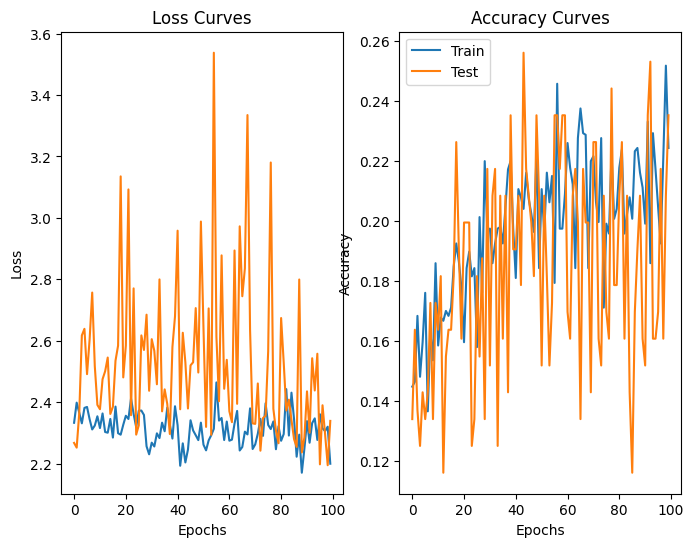

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (8,6))

ax[0].plot(range(100), results_transfer_learning['train loss'], label = "Train")
ax[0].plot(range(100), results_transfer_learning['test loss'], label = "Test")
ax[0].set_title('Loss Curves')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')

ax[1].plot(range(100), results_transfer_learning['train accuracy'], label = "Train")
ax[1].plot(range(100), results_transfer_learning['test accuracy'], label = "Test")
ax[1].set_title('Accuracy Curves')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epochs')

plt.legend()

## Predictions

In [ ]:
predictions(model = transfer_learning_model, validation_dataloader=validation_dataloader_TL, device=device)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

8 out of 16 correct
3 out of 16 correct
6 out of 16 correct
4 out of 16 correct
5 out of 16 correct
8 out of 16 correct
3 out of 4 correct


# References
* [Self-Supervised Representation Learning: Introduction, Advances and Challenges - Linus Ericsson, Henry Gouk, Chen Change Loy, Timothy M. Hospedales](https://arxiv.org/abs/2110.09327)
* [Labeled Faces in the Wild (LFW) Face Dataset](http://vis-www.cs.umass.edu/lfw/)
* [Tiny VGG Architecture](https://www.researchgate.net/figure/Main-architecture-of-VGGFace-network_tbl1_339634041)